In [2]:
from pattern.text.en import sentiment
from textblob import TextBlob
import spacy
import os
# from wordcloud import WordCloud
import random
import requests
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

nlp = spacy.load('en_core_web_sm')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harismalik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# INITIALIZING EVERYTHING

r = requests.get(
    'https://www.newsy.com/stories/commercial-companies-advance-space-exploration/')
# Now, we set the correct text encoding.

# Setting the correct text encoding of the HTML page
r.encoding = 'utf-8'
# Now, we get the HTML from the request object.

# Extracting the HTML from the request object
html = r.text
# Let us see how the HTML looks like. Let us take 500 characters from the HTML.

# Printing the first 500 characters in html
print(html[:500])

# Creating a BeautifulSoup object from the HTML
soup = BeautifulSoup(html)
# Getting the text out of the soup
text = soup.get_text()
# Let us have a look at the length of the text.

# total length
len(text)

<!DOCTYPE html><html lang="en"><head><!-- Google Analytics: GA4 --><script>var gtCode = 'G-D7R21VYTPB'; // live
                    var gtScriptElement = document.createElement('script')
                    gtScriptElement.src = `https://www.googletagmanager.com/gtag/js?id=${gtCode}&l=GA4DataLayer`;
                    gtScriptElement.onload = OnceLoaded;
                    document.getElementsByTagName('head')[0].appendChild(gtScriptElement);
                    function OnceLoaded() {
       


4904

In [4]:
print(text[0:1500])

Commercial Companies Advance Space Exploration




Scripps Newswatch livetoggle menuNewsU.S. NewsLifePoliticsBusinessScience/HealthWorldTechEntertainmentSportsShowsScheduleShow ListDocumentariesIn Real LifeNext LevelBellingcatAll DocsInvestigationsAboutTeamViewer SpotlightHotlineSupportWatch LiveSearchFollow Us






SpaceHow Commercial Companies Are Advancing Space ExplorationThere's competition among roughly a dozen private companies to launch new space stations.How Commercial Companies Are Advancing Space ExplorationNASAClayton SandellBy Clayton SandellFacebook ShareTweetEmailSMSPosted:  8:00 p.m. EDT Oct 29, 2021As astronauts blast off to the International Space Station this weekend on a SpaceX rocket, the company is also showing off a massive ship it says will one day take travelers far, far away.Newly released video shows the 'Starship' lifting into an aerial ballet of flips and turns before landing again. SpaceX hopes the ship will reach orbit for the first time next month and m

In [5]:
# CLEANING UP THE TEXT SO IT LOOKS MORE LIKE REAL ENGLISH

clean_text= text.replace("\n", " ")
clean_text= clean_text.replace("/", " ")
clean_text= ''.join([c for c in clean_text if c != "'"])
clean_text= ''.join([c for c in clean_text if c != "\""])

clean_text

'Commercial Companies Advance Space Exploration     Scripps Newswatch livetoggle menuNewsU.S. NewsLifePoliticsBusinessScience HealthWorldTechEntertainmentSportsShowsScheduleShow ListDocumentariesIn Real LifeNext LevelBellingcatAll DocsInvestigationsAboutTeamViewer SpotlightHotlineSupportWatch LiveSearchFollow Us       SpaceHow Commercial Companies Are Advancing Space ExplorationTheres competition among roughly a dozen private companies to launch new space stations.How Commercial Companies Are Advancing Space ExplorationNASAClayton SandellBy\xa0Clayton SandellFacebook ShareTweetEmailSMSPosted:  8:00 p.m. EDT Oct 29, 2021As astronauts blast off to the International Space Station this weekend on a SpaceX rocket, the company is also showing off a massive ship it says will one day take travelers far, far away.Newly released video shows the Starship lifting into an aerial ballet of flips and turns before landing again. SpaceX hopes the ship will reach orbit for the first time next month and 

In [6]:
# THIS MODEL IS THE NEGATIVITY MODEL THAT AIMS TO SEE IF THE TEXT IS NEUTRAL POSITIVE OR NEGATIVE, RESULTS HAVE BEEN PRINTED
# THIS MODEL USES THE MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# THIS MODEL HAS NOTHING TO DO WITH THE BELOW MODELS WHICH USE TEXTBLOB MODEL
# ONLY CHECKED THE FIRST 500 CHARACTERS SINCE THAT IS THE MAX FOR THIS MODEL

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
text7 = preprocess(clean_text[5: 500])
encoded_input = tokenizer(text7, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1) neutral 0.905
2) positive 0.0836
3) negative 0.0115


In [7]:
# TOKENIZING SENTENCES FOR THE NEXT MODEL, THE FIRST MODEL WILL NOT BE USED AGAIN, THE RESULTS ABOVE OF NEUTRAL, POSITIVE, NEGATIVE IS ALL WE NEED

sentence=[]
tokens = nlp(clean_text)
for sent in tokens.sents:
    sentence.append((sent.text.strip()))

sentence
print(len(sentence))


35


In [8]:
# HERE WE USE THE TEXTBLOB MODEL TO GET THE POLARITY AND SUBJECTIVITY OF THE ENTIRE ARTICLE

textblob_sentiment=[]
for s in sentence:
    txt= TextBlob(s)
    a= txt.sentiment.polarity
    b= txt.sentiment.subjectivity
    textblob_sentiment.append([s,a,b])
df_textblob = pd.DataFrame(textblob_sentiment, columns =['Sentence', 'Polarity', 'Subjectivity'])
df_textblob.head()


,Sentence,Polarity,Subjectivity
0,Commercial Companies Advance Space Exploration...,0.100000,0.150000
1,LiveSearchFollow Us SpaceHow Commercial ...,0.009091,0.307386
2,How Commercial Companies Are Advancing Space E...,0.000000,0.000000
3,"Oct 29, 2021As astronauts blast off to the Int...",0.050000,0.750000
4,Newly released video shows the Starship liftin...,0.136364,0.454545


Text(0.5, 9.444444444444438, 'Sentence Polarity (Textblob)')

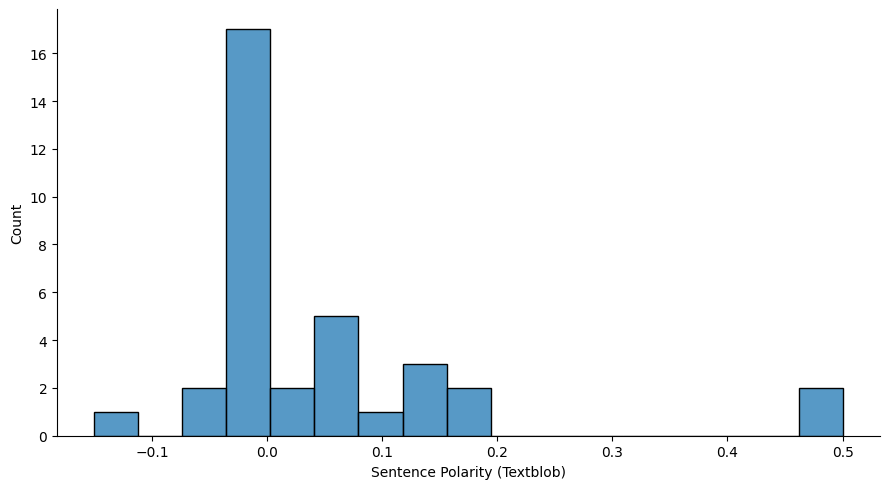

In [9]:
# DISPLAYING POLARITY GRAPH

sns.displot(df_textblob["Polarity"], height= 5, aspect=1.8)
plt.xlabel("Sentence Polarity (Textblob)")

Text(0.5, 9.444444444444438, 'Sentence Subjectivity (Textblob)')

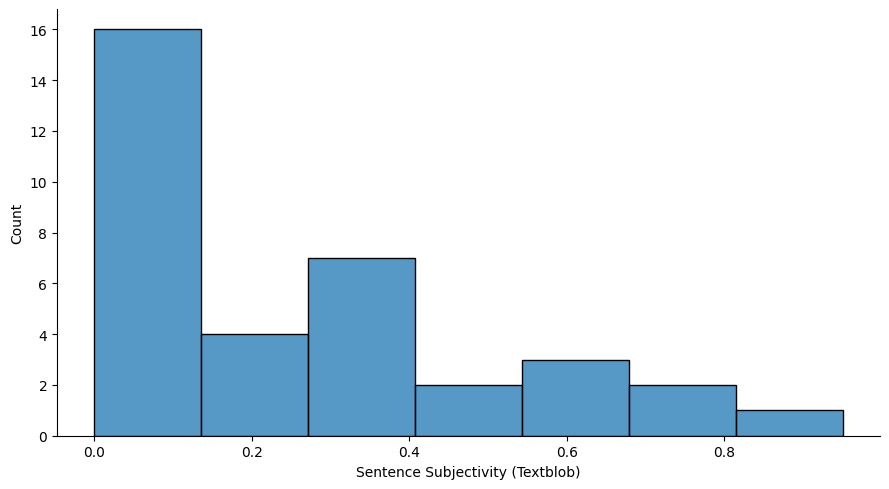

In [10]:
# DISPLAY SUBJECTIVITY

sns.displot(df_textblob["Subjectivity"], height= 5, aspect=1.8)
plt.xlabel("Sentence Subjectivity (Textblob)")

In [11]:
# DOES SAME THING AS TEXT BLOB

"""
pattern_sentiment=[]
for s in sentence:
    res= sentiment(s)
    c= res[0]
    d= res[1]

    pattern_sentiment.append([s,c,d])

df_pattern = pd.DataFrame(textblob_sentiment, columns =['Sentence', 'Polarity', 'Subjectivity'])
df_pattern.head()"""

"\npattern_sentiment=[]\nfor s in sentence:\n    res= sentiment(s)\n    c= res[0]\n    d= res[1]\n\n    pattern_sentiment.append([s,c,d])\n\ndf_pattern = pd.DataFrame(textblob_sentiment, columns =['Sentence', 'Polarity', 'Subjectivity'])\ndf_pattern.head()"

In [12]:
# NOW SETTING UP THE WORD COUNTER, SEEING IF CERTAIN ARTICLES USE MORE WORDS THAN OTHERS,
# LOOK AT THE GRAPH BELOW AND YOU'LL UNDERSTAND WHAT THE CODE DOES

#Creating the tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+|[.,]')

#Tokenizing the text
tokens1 = tokenizer.tokenize(clean_text)
print(tokens[0:10])
print(len(tokens))

Commercial Companies Advance Space Exploration     Scripps Newswatch livetoggle menuNewsU.S.
891


In [14]:
words = []
# Looping through the tokens and make them lower case
for word in tokens1:
    words.append(word.lower())
#Now, we need to remove the stopwords.
words_new = []
#Now we have to remove stopwords
#Stop words are a set of commonly used words in any language. 
#For example, in English, “the”, “is” and “and”, would easily qualify as stop words. 
#In NLP and text mining applications, stop words are used to eliminate unimportant words, 
#allowing applications to focus on the important words instead.
#English stop words from nltk
stop_words = set(stopwords.words('english'))
#Appending to words_new all words that are in words but not in sw
for word in words:
    if word not in stop_words:
        words_new.append(word)
#With this, the stopwords have been removed. Let us check the length of the text.

print(words_new[0:10])
len(words_new)


['commercial', 'companies', 'advance', 'space', 'exploration', 'scripps', 'newswatch', 'livetoggle', 'menunewsu', '.']


563

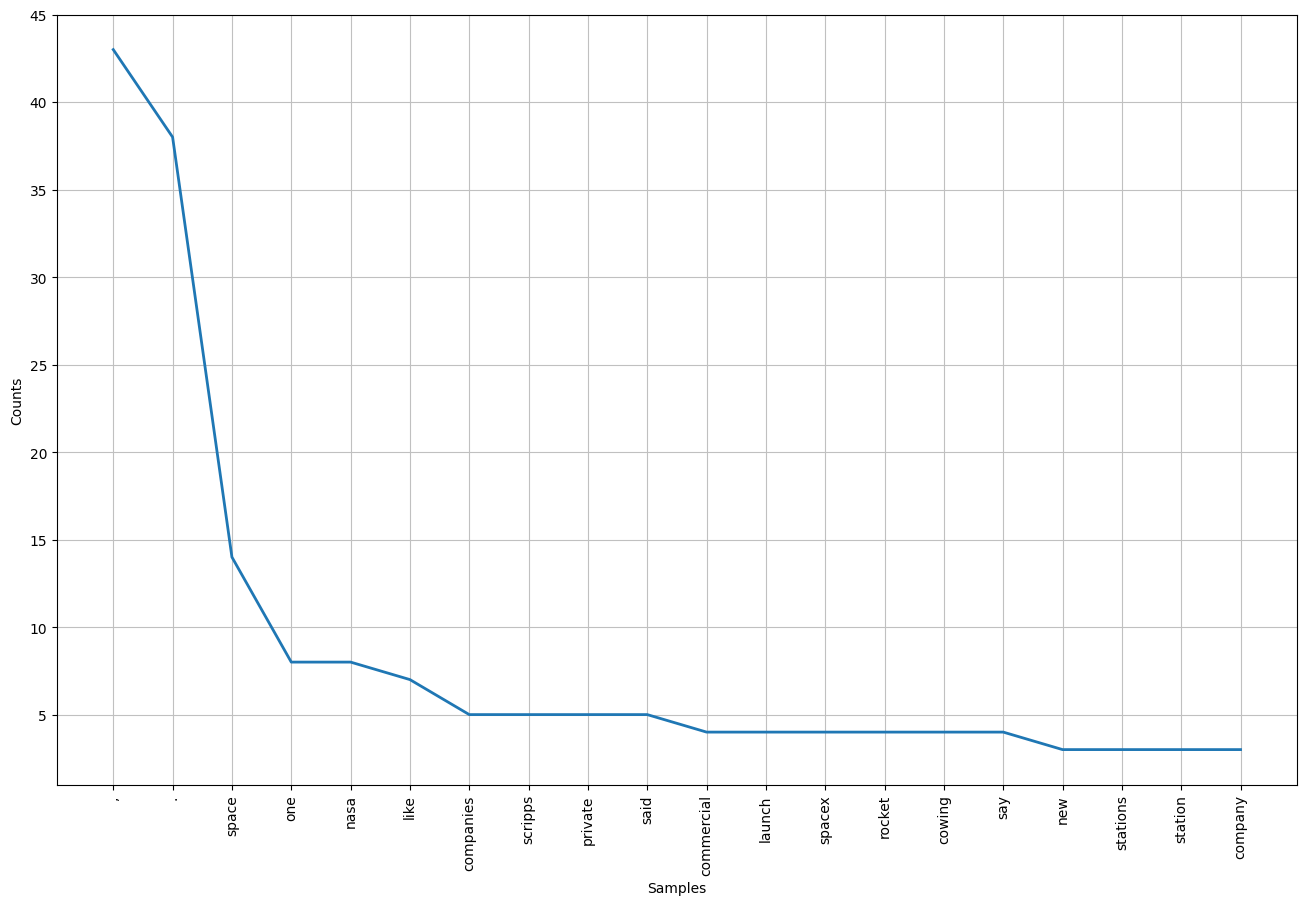

<Axes: xlabel='Samples', ylabel='Counts'>

In [15]:
#The frequency distribution of the words
freq_dist = nltk.FreqDist(words_new)

#Frequency Distribution Plot
plt.subplots(figsize=(16,10))
freq_dist.plot(20)